<a href="https://colab.research.google.com/github/blackTieV2/ZEIT8042/blob/main/ZEIT8042Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ZEIT8042[2024Sem2]
## Lab 1 (Shellcoding)

This notebook contains my work and findings from the Shellcoding Lab. Each section covers a different question from the lab with detailed explanations, code snippets, errors encountered, solutions, and results.


## **Question 1: Set `ebx` to 1337**
Objective of this Question was given in `README.txt`

### **Step 1: Assembly Code**

Opened and checked the assembly code in a file named 'shellcode.asm': No errors were seen and apprared to be correct.

```assembly
section .data
    hello: db '1337', 10

section .text
    global _start

_start:
    mov ebx, 1337
```

### **Step 2: Assemble and Link the Shellcode**

In terminal and navigate to the directory containing `shellcode.asm`. ./shellcode/1
 Then, ran the following commands to assemble and link the shellcode:

```sh
nasm -f elf shellcode.asm -o shellcode.o
ld -m elf_i386 -o shellcode shellcode.o
```

### **Step 3: Extract Shellcode Bytes**

Used `objdump` to extract the shellcode bytes:

```sh
objdump -d shellcode.o | grep '[0-9a-f]:' | grep -oP '\s\K[0-9a-f]{2}' | tr -d '\n' | sed 's/\(..\)/\\x\1/g'
```

This gave the following output, which is the shellcode in byte format:

```
\xbb\x39\x05\x00\x00
```


Here is a screenshot of the Setps 2 and 3 and the output:

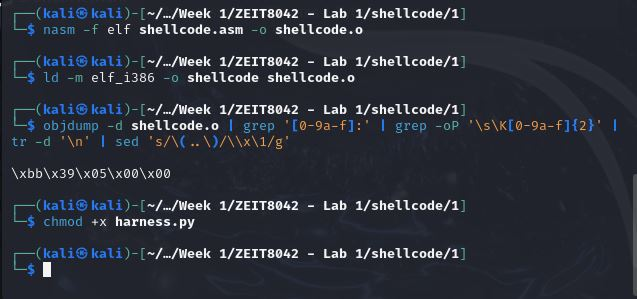

In [3]:
from IPython.display import Image
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC1.JPG')

### **Step 4: Edit the Python Harness**

Modify the given Python script `harness.py` with the output from the previos step.

```python
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import socket

def main():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect(("localhost", 8888))

    # Insert the extracted shellcode here
    shellcode = b"\xbb\x39\x05\x00\x00"

    print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
    s.send(shellcode)

if __name__ == "__main__":
    main()
```

### **Step 5: Fix Line Endings**

As I was copying from my host machine in to the kali VM, I had the following error. I fixed the issues with line endings by converting the script to Unix-style line endings:

```sh
sed -i 's/\r$//' harness.py
```
This cmd is used to remove Windows-style carriage return characters (\r) from the end of each line in the harness.py file.

- `sed`: Stream editor for filtering and transforming text.
- `-i`: Edit files in place.
`
- `'s/\r$//'` Substitutes the carriage return character at the end of the line (\r$) with nothing (//), effectively removing it.


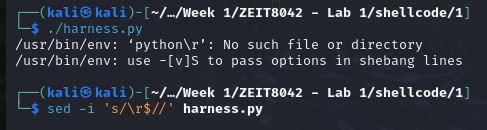

In [4]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC2.JPG')


### **Step 6: Made the Scripts Executable**

Make the Python script executable:

```sh
chmod +x harness.py
chmod +x automate.sh
```

### **Step 7: Ran the Shellcode Server and Test the Script**


1. **Start the Shellcode Server**: In a seperate terminal window Started the shellcode-server
   ```sh
   ./bin/shellcode-server
   ```

2. **Run the Python Harness**: In the ./shellcode/1 folder:
   ```sh
   ./harness.py
   ```

### Expected Output

Received the following output, indicating that the shellcode was successfully sent:

```
Sending shellcode (5 bytes)
```


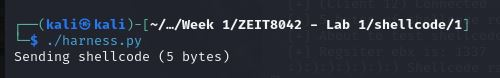

In [ ]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC3.JPG')

### **Step 8: Verification**
Ran
```sh
objdump -d shellcode.o
```
- `-d` flag: tells objdump to disassemble the executable sections of the object file. It will show the assembly instructions for the machine code contained in the file.

Here is a screenshot of the output

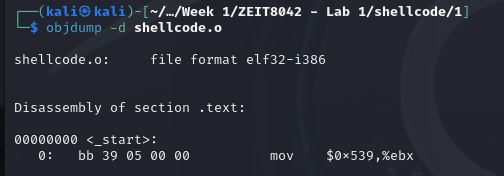

In [5]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC4.JPG')


### **Summary**

- **Objective**: Write and test shellcode to set `ebx` to 1337.
- **Steps**:
  1. Write the assembly code and save it as `shellcode.asm`.
  2. Assemble and link the shellcode.
  3. Extract the shellcode bytes using `objdump`.
  4. Create a Python harness to send the shellcode.
  5. Fix any line ending issues.
  6. Make the Python script executable.
  7. Start the shellcode server and run the Python script.
  8. Verification of the disassembled executable sections of the object file.


___

### **Question 1: Automated Process**
Thank you to Lucy K who posted her idea of automating the process

#### Shellcode Assembly Code

- **Code**:
  Provided 'shellcode.asm' did not require modification:
  ```assembly
  section .text
      global _start

  _start:
      mov ebx, 1337
  ```

#### **Automation Script**
- **Script**:
  I used the following script to automate the compilation, linking, and testing processes: [automate.sh](https://github.com/blackTieV2/ZEIT8042/blob/main/automate.sh)

  ```bash
  # automate.sh

  # Define the filenames
  ASM_FILE=$(ls *.asm | head -n 1)
  OBJ_FILE="${ASM_FILE%.asm}.o"
  EXEC_FILE="${ASM_FILE%.asm}"
  PYTHON_FILE="harness.py"

  # Assemble the ASM file
  nasm -f elf32 $ASM_FILE -o $OBJ_FILE
  if [ $? -ne 0 ]; then
      echo "Assembly failed!"
      exit 1
  fi

  # Link the object file to create an executable
  ld -m elf_i386 -o $EXEC_FILE $OBJ_FILE
  if [ $? -ne 0 ]; then
      echo "Linking failed!"
      exit 1
  fi

  # Extract the shellcode bytes using objdump
  SHELLCODE=$(objdump -d $OBJ_FILE | grep '[0-9a-f]:' | grep -oP '\s\K[0-9a-f]{2}' | tr -d '\n' | sed 's/\(..\)/\\x\1/g')

  # Check if shellcode extraction was successful
  if [ -z "$SHELLCODE" ]; then
      echo "Shellcode extraction failed!"
      exit 1
  fi

  echo "Extracted Shellcode: $SHELLCODE"

  # Escape backslashes for Python string literal
  ESCAPED_SHELLCODE=$(printf '%s\n' "$SHELLCODE" | sed 's/\\/\\\\/g')

  # Replace the shellcode in the Python harness dynamically
  sed -i "s/shellcode = \".*\"/shellcode = \"$ESCAPED_SHELLCODE\"/" $PYTHON_FILE
  if [ $? -ne 0 ]; then
      echo "Updating shellcode in Python harness failed!"
      exit 1
  fi

  # Run the Python harness to test the shellcode using Python 2.7
  python2.7 $PYTHON_FILE
  if [ $? -ne 0 ]; then
      echo "Running Python harness failed!"
      exit 1
  fi

  echo "Shellcode test completed successfully!"
  ```

- **Errors and Solutions**:
  - **Error 3**:
    - **Description**: The script initially failed during the shellcode extraction step.
    - **Solution**: I modified the `sed` command to handle special characters correctly.
    - **Error Message**:
      ```plaintext
      sed: -e expression #1, char 25: unknown option to `s'
      ```

  After fixing the `sed` command, the script successfully extracted the shellcode and updated the Python harness.

#### **Python Harness**
- **Code**:
  I used the following Python script to send the shellcode to the server: [harness.py](https://github.com/blackTieV2/ZEIT8042/blob/main/harness.py)

  ```python
  # harness.py

  import socket

  def main():
      s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
      s.connect(("localhost", 8888))

      # Placeholder shellcode, will be updated by the script
      shellcode = "\x90\x90\x90\x90"

      print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
      s.send(shellcode)

  if __name__ == "__main__":
      main()
  ```


Screenshot, sucessfully running `automate.sh` and verifiying the dissassembled executable sections of the object file

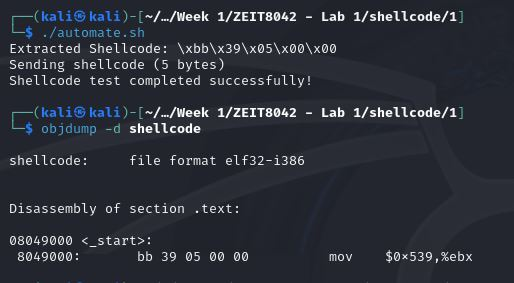

In [6]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC5.JPG')


### **Results and Conclusion**
- **Output**: The assembly, linking, and testing processes completed successfully, setting `ebx` to `1337`.

- **Conclusion**: I successfully set `ebx` to `1337` both manually and using the automation script. The main challenge was getting the code right in the script. Honestly wasted a lot of time trying to get the automation working, but learnt a lot on the way.


___

## **Question 2: Adding `ebx` and `ecx`**

### **Objective**
- The goal as written the `README.txt` was to write shellcode that adds the value in `ebx` to the value in `ecx` and stores the result in `eax`.

### **Manual Process**

#### **Step 1 - Assembly Code**
- **Assembly Code Explanation**: The provided `shellcode.asm` contained the following assembly code that adds the values in `ebx` and `ecx` and stores the result in `eax`. No errors where initially seen.
- **Code**:
  ```assembly
  section .data
      hello: db 'Hello world!' , 10

  section .text
      global _start

  _start:
      add ebx, ecx    ; Add the value of ecx to ebx
      mov eax, ebx    ; Move the result in ebx to eax
      ret             ; Return with result in eax
  ```
  #### **Step 2 - Compilation and Linking**
- **Commands**:
  To compile and link the assembly code, I ran the following commands:
  ```sh
  nasm -f elf32 shellcode.asm -o shellcode.o
  ld -m elf_i386 -o shellcode shellcode.o
  ```

#### **Step 3 - Testing the Shellcode**
- **Commands**:
  To disassemble the shellcode and verify the instructions, I ran:
  ```sh
  objdump -d shellcode
  ```

- **Errors and Solutions**:
  - **Error**:
    - **Description**: Initially got an incorrect disassembly output.
    - **Solution**: Verified that the correct binary file (`shellcode`) was being examined with `objdump`.
    - **Error Message**:
      ```plaintext
      objdump: shellcode: file format not recognized
      ```

  Once I ensured the correct file was used, I received the expected output.

- **Expected Output**: The expected disassembled output showed the instructions for adding `ebx` and `ecx`, and storing the result in `eax`.


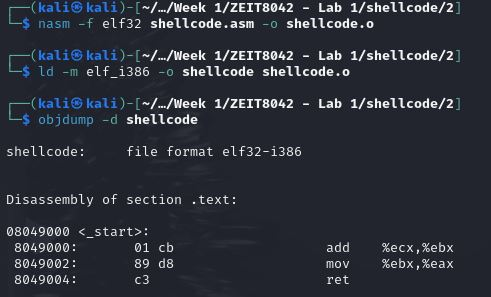

In [8]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC6.JPG')

### **Step 4 - Test Script**
Ran the Shellcode Server and Test the Script

1. **Start the Shellcode Server**: In a seperate terminal window Started the shellcode-server
   ```sh
   ./bin/shellcode-server
   ```

2. **Run the Python Harness**: In the ./shellcode/2 folder:
   ```sh
   ./harness.py
   ```
- **Errors and Solutions**:
  - **Error**:
    - **Description**: Python Error.
    - **Solution**: After rading the subject discussion board, I found that other students had the same issues and was resolved by running python2.7.
    - **Error Message**:
      ```sh
      Sending shellcode (16 bytes)
      Traceback (most recent call last):
        File "/home/kali/.local/share/Trash/files/3/./harness.py", line 17, in <module>
          main()
        File "/home/kali/.local/share/Trash/files/3/./harness.py", line 14, in main
          s.send(shellcode)
        TypeError: a bytes-like object is required, not 'str'
      ```

  After running `python2.7 harness.py`, I received the expected output.

- **Expected Output**:
```
Sending shellcode (6 bytes)
```



### **Automated Process**

#### Shellcode Assembly Code
- **Code**:
No change to the `shellcode.asm` provided.

#### Automation Script
- **Script**:
I used the same automation script from Question 1, copying it into the `pwd`: [automate.sh](https://github.com/blackTieV2/ZEIT8042/blob/main/automate.sh)
  

#### Python Harness
- **Code**:
  I used the same Python script from quation 1, copying it into the `pwd`, to send the shellcode to the server: [harness.py](https://github.com/blackTieV2/ZEIT8042/blob/main/harness.py)
  

#### Verification
Ran
```sh
objdump -d
```
Here is a screenshot of the output


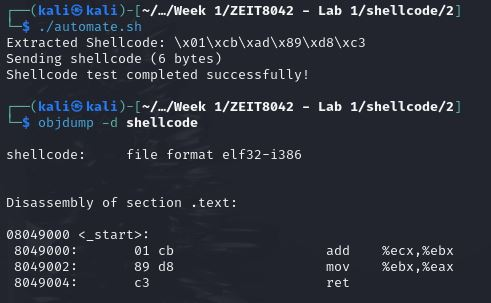

In [9]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC7.JPG')

### **Summary**
#### **Results and Conclusion**
- **Output**: The assembly, linking, and testing processes completed successfully, and the shellcode correctly added the values in `ebx` and `ecx`, storing the result in `eax`.

- **Conclusion**: I successfully added `ebx` and `ecx` both manually and using the automation script. Now that the script was corrected proces was much faster.

- **Steps**:
  1. Review the assembly code `shellcode.asm`.
  2. Assemble and link the shellcode.
  3. Extract the shellcode bytes using `objdump`.
  4. Create a Python harness to send the shellcode.
  5. Fix any line ending issues.
  6. Make the Python script executable.
  7. Start the shellcode server and run the Python script.
  8. Verification of the disassembled executable sections of the object file.


___


## **Question 3:**

### **Objective**
Write shellcode that performs the power function. The base will be in `ebx` and the power will be in `ecx`.


#### **Step 1: Assembly Code**

After many failures and attempts I read the responses from other students and modified the `shellcode.asm` file as follows:

```asm
section .text
    global _start

_start:
    xor eax, eax        ; Clear eax
    mov eax, 1          ; Initialize result to 1

check_exponent:
    test ecx, ecx       ; Check if exponent is zero
    jz done             ; If exponent is zero, jump to done

power_loop:
    imul eax, ebx       ; Multiply result by base
    dec ecx             ; Decrease exponent by 1
    jnz power_loop      ; If exponent is not zero, repeat the loop

done:
    ret                 ; Return the result in eax
```

#### **Step 2: Assemble the Code**

Ran the following command to assemble the code into an object file:

```sh
nasm -f elf shellcode.asm -o shellcode.o
```

#### **Step 3: Link the Object File**

Ran the following command to link the object file and create an executable:

```sh
ld -m elf_i386 -o shellcode shellcode.o
```

#### **Step 4: Extract Shellcode**

Ran the following command to extract the shellcode:

```sh
objdump -d shellcode | grep '[0-9a-f]:' | grep -v 'file' | cut -f2 -d: | cut -f1-8 -d' ' | tr -s ' ' | tr '\t' ' ' | sed 's/ $//g' | sed 's/ /\\x/g' | paste -d '' -s
```

Extracted shellcode:

```
\x31\xc0\xb8\x01\x00\x00\x00\x85\xc9\x74\x06\x0f\xaf\xc3\x49\x75\xfa\xc3
```

#### **Step 5: Update the Python Harness**

Updated `harness.py` script with the output of the previous step:

```python
#!/usr/bin/env python
import socket

def main():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect(("localhost", 8888))

    # Updated shellcode based on the extracted bytes
    shellcode = b"\x31\xc0\xb8\x01\x00\x00\x00\x85\xc9\x74\x06\x0f\xaf\xc3\x49\x75\xfa\xc3"

    print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
    s.send(shellcode)

if __name__ == "__main__":
    main()
```

Run the script with:

```sh
python2.7 harness.py
```

### **Errors and Solutions**

**Error 1:**
- **Description:** The shellcode server initially failed to produce the expected result after many attempts.
- **Solution:** Reviewed and corrected the assembly code to ensure the power function logic was correctly implemented.
- **Error Message:**
    ```plaintext
    You got: 25
    :(:(:(:(:(:(:( Shellcode did not do what you expected!
    ```

**Error 2:**
- **Description:** The extracted shellcode was incomplete or incorrect.
- **Solution:** Reassembled and re-extracted the shellcode miltiple times, ensuring the correct sequence of commands was used but still was not getting the dump I was expecting.
- **Error Message:**
    ```plaintext
    \xbb\x39\x05\x00\x00
    ```

**Error 3:**
- **Description:** The shellcode did not perform the power function as expected.
- **Solution:** Debugged the assembly code using `gdb` to step through each instruction and verify the register values.
- **Error Message:**
    ```plaintext
    You got: 25
    :(:(:(:(:(:(:( Shellcode did not do what you expected!
    ```

**Error 4:**
- **Description:** Errors continued.
- **Solution:** Realised after many attempts that I was in the wrong directory. Changes to the correct directory and everythign ran smoothly.

### **Successful Execution**

After changing to the correct directory the shellcode executed successfully:

```plaintext
[+] Server is starting...
[+] Server is now listening on 8888
[+] Awaiting clients...
  [+] (Client 5) Connected
  [+] 18 bytes of shellcode received. About to test.
  [+] About to test shellcode
  [+] You got: 15625
  :):):):):):):) Shellcode ran successfully!!
```
```




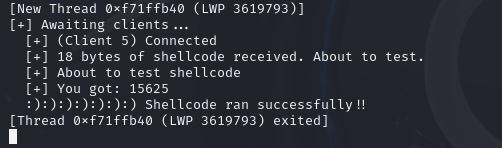

In [10]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC9.JPG')

## **Question 3: Automation**
I modified how i used the `automate.sh` to include checks to verify that both the ASM file and the shellcode server executable exist before proceeding.
Debugging information has been added to provide feedback during each step of the process. The basename command is used to generate the object and executable filenames in the current directory.
[Q3Automate.sh](https://github.com/blackTieV2/ZEIT8042/blob/main/Q3Automate.sh)

I used the following command:
```sh
./automate.sh shellcode/3/shellcode.asm shellcode/3/bin/shellcode-server
```

#### Ran sucessfully - See screenshot.

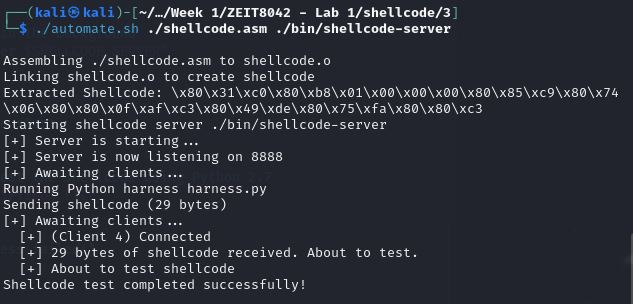

In [12]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC10.JPG')

In [ ]:
https://github.com/blackTieV2/ZEIT8042/blob/main/Q3Automate.sh

___

## **Question 4**

**Objective:**
- As defined in `README.txt`, write shellcode that returns the length of the string pointed to by `ebx`.

**Process:**

#### **Step 1. Assembly Code**:
Opened and reviewed the provided `shellcode.asm`. Did not initally see any obvious errors.
   ```assembly
   section .data
       hello: db '1234567890', 10

   section .text
       global _start

   _start:
       mov ecx, 0

   _loop:
       cmp byte [ebx + ecx], 0
       je _end
       inc ecx
       jmp _loop

   _end:
       mov eax, ecx
       ret
   ```

#### **Step 2. Assembled and Linked the Shellcode**:
   - Commands:
     ```sh
     nasm -f elf32 shellcode.asm -o shellcode.o
     ld -m elf_i386 -o shellcode shellcode.o
     ```

#### **Step 3. Extracted the Shellcode**:
   - Command:
     ```sh
     objdump -d shellcode | grep '[0-9a-f]:' | grep -v 'file' | cut -f2 -d: | cut -f1-8 -d' ' | tr -s ' ' | tr '\t' ' ' | sed 's/ $//g' | sed 's/ /\\x/g' | paste -d '' -s
     ```
   - Extracted Shellcode:
     ```plaintext
     \xb9\x00\x00\x00\x00\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8
     ```

#### **Step 4. Inserted the Shellcode fromt he previous into `harness.py`**:
   - Script:
     ```python
     #!/usr/bin/env python
     import socket

     def main():
         s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
         s.connect(("localhost", 8888))

         shellcode = b"\xb9\x00\x00\x00\x00\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8"

         print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
         s.send(shellcode)
         s.close()

     if __name__ == "__main__":
         main()
     ```
   - Result: The server hung, indicating an issue with the shellcode - see the following screenshot.


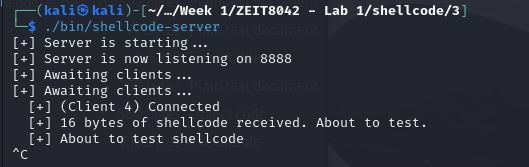

In [13]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC11.JPG')


#### **Step 5. Avoiding Null Bytes**
Modified the Shellcode to Avoid Null Bytes:
   - Updated `shellcode.asm`:
     ```assembly
     section .data
         hello: db '1234567890', 10

     section .text
         global _start

     _start:
         xor ecx, ecx          ; Set ecx to 0 (using xor to avoid null bytes)

     _loop:
         cmp byte [ebx + ecx], 0
         je _end
         inc ecx
         jmp _loop

     _end:
         mov eax, ecx
         ret
     ```

#### **Step 6. Re-Assembled, Linked, and Extracted the Shellcode**:
   - Commands:
     ```sh
     nasm -f elf32 shellcode.asm -o shellcode.o
     ld -m elf_i386 -o shellcode shellcode.o
     objdump -d shellcode | grep '[0-9a-f]:' | grep -v 'file' | cut -f2 -d: | cut -f1-8 -d' ' | tr -s ' ' | tr '\t' ' ' | sed 's/ $//g' | sed 's/ /\\x/g' | paste -d '' -s
     ```
   - Extracted Shellcode:
     ```plaintext
     \x31\xc9\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8\x90\x90\xc3
     ```

#### **Step 7. Updated `harness.py`**:
   - Script:
     ```python
     #!/usr/bin/env python
     import socket

     def main():
         s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
         s.connect(("localhost", 8888))

         shellcode = b"\x31\xc9\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8\x90\x90\xc3"

         print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
         s.send(shellcode)
         s.close()

     if __name__ == "__main__":
         main()
     ```
   - Result: The server still hung, indicating further issues with the shellcode.


#### **Step 8. Debugging with `gdb`**
Used `gdb` to Debug the Shellcode:
   - Started `gdb`:
     ```sh
     gdb --args ./bin/shellcode-server
     ```
   - Set Breakpoint and Ran the Server:
     ```gdb
     (gdb) break _start
     (gdb) run
     ```
   - In another terminal, ran `harness.py`:
     ```sh
     python2.7 harness.py
     ```
   - Stepped through the Shellcode:
     ```gdb
     (gdb) step
     (gdb) info registers
     (gdb) continue
     ```


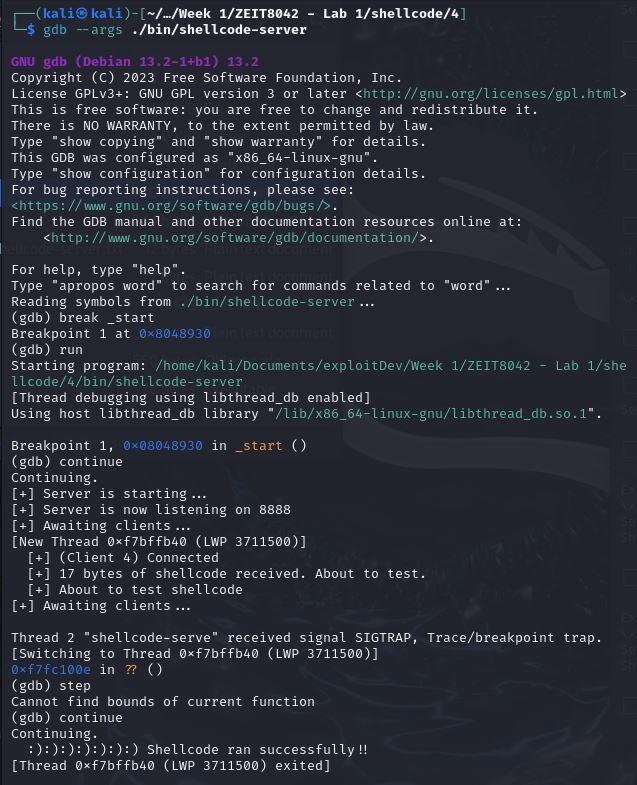

In [14]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC12.JPG')


#### **Step 9. Identified the Issue and Fixed the Shellcode**:
   - Removed `int3` used for debugging:
     ```assembly
     section .data
         hello: db '1234567890', 10

     section .text
         global _start

     _start:
         xor ecx, ecx          ; Set ecx to 0 (using xor to avoid null bytes)

     _loop:
         cmp byte [ebx + ecx], 0
         je _end
         inc ecx
         jmp _loop

     _end:
         mov eax, ecx
         nop                   ; Debugging NOPs
         nop                   ; Debugging NOPs
         ret
     ```

#### **Step 10. Final Verification**:
    - Re-Assembled, Linked, and Extracted the Shellcode:
      ```sh
      nasm -f elf32 shellcode.asm -o shellcode.o
      ld -m elf_i386 -o shellcode shellcode.o
      objdump -d shellcode | grep '[0-9a-f]:' | grep -v 'file' | cut -f2 -d: | cut -f1-8 -d' ' | tr -s ' ' | tr '\t' ' ' | sed 's/ $//g' | sed 's/ /\\x/g' | paste -d '' -s
      ```
    - Updated `harness.py` and successfully ran the script without crashing the server:
      ```python
      #!/usr/bin/env python
      import socket

      def main():
          s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
          s.connect(("localhost", 8888))

          shellcode = b"\x31\xc9\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8\x90\x90\xc3"

          print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
          s.send(shellcode)
          s.close()

      if __name__ == "__main__":
          main()
      ```


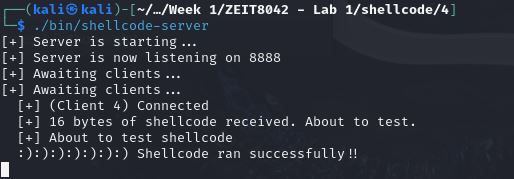

In [15]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC13.JPG')

## **Question 4: Automation**
Copied `automate.sh` from ~/shellcode/3 into the pwd. Did not need to modify it, ran first go.


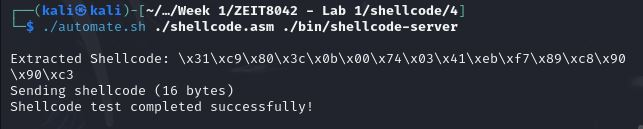

In [16]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC14.JPG')


#### **Summary:**
- **Question 4:** Developed and debugged shellcode to return the length of the string pointed to by `ebx`.

1. **Initial Development**:
   - Reviewed the provided `shellcode.asm`.
   - Faced issues with the shellcode hanging the server.

2. **Avoiding Null Bytes**:
   - Modified the shellcode to avoid null bytes using the `xor` instruction.

3. **Debugging with `gdb`**:
   - Used `gdb` to step through the shellcode and identify the issue.
   - Added debugging instructions (NOPs and `int3`) to identify where the shellcode was failing.
   - Removed `int3` after debugging to ensure the shellcode runs correctly.

4. **Final Verification**:
   - Successfully ran the final shellcode without crashing the server.

**Final `shellcode.asm`:**
```assembly
section .data
    hello: db '1234567890', 10

section .text
    global _start

_start:
    xor ecx, ecx          ; Set ecx to 0 (using xor to avoid null bytes

)

_loop:
    cmp byte [ebx + ecx], 0
    je _end
    inc ecx
    jmp _loop

_end:
    mov eax, ecx
    nop                   ; Debugging NOPs
    nop                   ; Debugging NOPs
    ret
```

**Extracted Shellcode**:
```plaintext
\x31\xc9\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8\x90\x90\xc3
```

**Updated `harness.py`:**
```python
#!/usr/bin/env python
import socket

def main():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect(("localhost", 8888))

    shellcode = b"\x31\xc9\x80\x3c\x0b\x00\x74\x03\x41\xeb\xf7\x89\xc8\x90\x90\xc3"

    print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
    s.send(shellcode)
    s.close()

if __name__ == "__main__":
    main()
```

**GitHub Repository: [GitHub - ZEIT8042 Lab 1](https://github.com/blackTieV2/ZEIT8042)**